In [ ]:
import os
import random
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, datasets
from tqdm.notebook import tqdm


#Classification using FAST detector, FREAK descriptor and SVM classifier.
data_dir = './data'

In [2]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """
    Custom dataset that includes image file paths and retains the label.
    Extends torchvision.datasets.ImageFolder
    """
    def __getitem__(self, index):
        # This is what ImageFolder normally returns 
        original_tuple = super().__getitem__(index)  # (image, label)

        # The image file path
        path = self.samples[index][0]
        # just needs the filename (without the full path):
        filename = os.path.basename(path)

        # Add path to the tuple
        return original_tuple + (filename,)

In [3]:
skyview_dataset = ImageFolderWithPaths(data_dir)

Number of classes: 15
Classes: ['Agriculture', 'Airport', 'Beach', 'City', 'Desert', 'Forest', 'Grassland', 'Highway', 'Lake', 'Mountain', 'Parking', 'Port', 'Railway', 'Residential', 'River']
('./Aerial_Landscapes\\Agriculture\\002.jpg', 0)


(-0.5, 255.5, 255.5, -0.5)

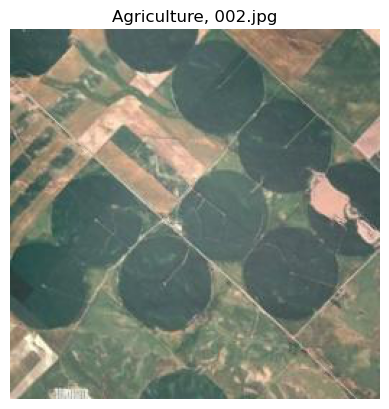

In [15]:
print(f"Number of classes: {len(skyview_dataset.classes)}")
print(f"Classes: {skyview_dataset.classes}")
print(skyview_dataset.samples[1])
plt.imshow(skyview_dataset[1][0])
plt.title(f"{skyview_dataset.classes[skyview_dataset[1][1]]}, {skyview_dataset[1][2]}")
plt.axis('off')

In [8]:
# Create the FAST detector and FREAK descriptor
# Note: Requires OpenCV with xfeatures2d (opencv-contrib)
# Install with `pip install opencv-contrib-python`
fast = cv2.FastFeatureDetector_create()
freak = cv2.xfeatures2d.FREAK_create()

In [ ]:
class ImageFeature():
    """
    Class to hold image features and their descriptors.
    """
    def __init__(self, dataset:ImageFolderWithPaths, detector, descriptor, n_clusters:int=100, seed:int=42):
        self.dataset = dataset
        self.detector = detector
        self.descriptor = descriptor
        self.n_clusters = n_clusters
        self.seed = seed
        self.labels = [sample[1] for sample in dataset.samples]
        self.index = 0

        self.kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=seed)
        self.descriptors = [self.extract_descriptors(img[0]) for img in tqdm(dataset.samples, desc="Extracting descriptors")]
        # Fit KMeans on all descriptors
        stacked_descriptors = np.vstack(self.descriptors).astype(np.float32)
        for _ in tqdm(range(self.kmeans.max_iter), desc="Fitting KMeans"):
            self.kmeans.partial_fit(stacked_descriptors)
        self.features = [self.image_to_bow(desc) for desc in tqdm(self.descriptors, desc="Creating BoW features")]

    def __getitem__(self, index):
        """
        Returns the BoW feature vector and its label.
        """        
        feature = self.features[index]
        label = self.dataset.classes[self.dataset.samples[index][1]]
        return feature, label

    def extract_descriptors(self, image_path):
        """
        Loads an image, detects FAST keypoints, computes FREAK descriptors.
        Returns the descriptors as a NumPy array of shape [num_keypoints, descriptor_dim].
        """
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"Image at {image_path} could not be loaded.")

        # Detect keypoints
        keypoints = self.detector.detect(img, None)
        # Compute FREAK descriptors
        keypoints, descriptors = self.descriptor.compute(img, keypoints)
        # No descriptors found, return a zero descriptor
        if descriptors is None:
            descriptors = np.zeros(64, dtype=np.float32).reshape(1, -1)
        return descriptors

    def pil_to_greyscale_cv2(pil_image):
        """
        Converts a PIL.Image.Image to greyscale using OpenCV.
        """
        # Convert PIL image to NumPy array
        image_array = np.array(pil_image)
        # Convert to greyscale using OpenCV
        grey_image = cv2.cvtColor(image_array, cv2.COLOR_RGB2GRAY)
        return grey_image

    def image_to_bow(self, descriptors):
        """
        Given an array of local descriptors and a trained KMeans model,
        returns the normalized histogram (BoW feature).
        """
        if descriptors is None or len(descriptors) == 0:
            # If no descriptors, return a zero histogram
            histogram = np.zeros(self.n_clusters, dtype=np.float32).reshape(1, -1)
            return histogram

        cluster_indices = self.kmeans.predict(descriptors.astype(np.float32))
        histogram, _ = np.histogram(cluster_indices, bins=np.arange(self.n_clusters+1), density=False)
        # Normalize histogram
        histogram = histogram.astype(np.float32)
        # Avoid division by zero
        histogram /= (histogram.sum() + 1e-7)
        return histogram

In [74]:
feature_set = ImageFeature(skyview_dataset, fast, freak, n_clusters=50, seed=42)

Extracting descriptors:   0%|          | 0/12000 [00:00<?, ?it/s]

Fitting KMeans:   0%|          | 0/100 [00:00<?, ?it/s]

Creating BoW features:   0%|          | 0/12000 [00:00<?, ?it/s]

In [75]:
svm = LinearSVC(random_state=42)
train_set, test_set, train_labels, test_labels = train_test_split(
    feature_set.features, feature_set.labels, test_size=0.2, random_state=42, stratify=feature_set.labels)
svm.fit(train_set, train_labels)

LinearSVC(random_state=42)

Accuracy: 44.29%
              precision    recall  f1-score   support

           0       0.39      0.49      0.43       160
           1       0.71      0.03      0.06       160
           2       0.36      0.67      0.47       160
           3       0.49      0.32      0.38       160
           4       0.49      0.23      0.31       160
           5       0.43      0.57      0.49       160
           6       0.43      0.69      0.53       160
           7       0.40      0.68      0.50       160
           8       0.30      0.06      0.09       160
           9       0.49      0.31      0.38       160
          10       0.53      0.77      0.63       160
          11       0.58      0.60      0.59       160
          12       0.52      0.33      0.41       160
          13       0.43      0.86      0.57       160
          14       0.38      0.04      0.07       160

    accuracy                           0.44      2400
   macro avg       0.46      0.44      0.39      2400
weighted 

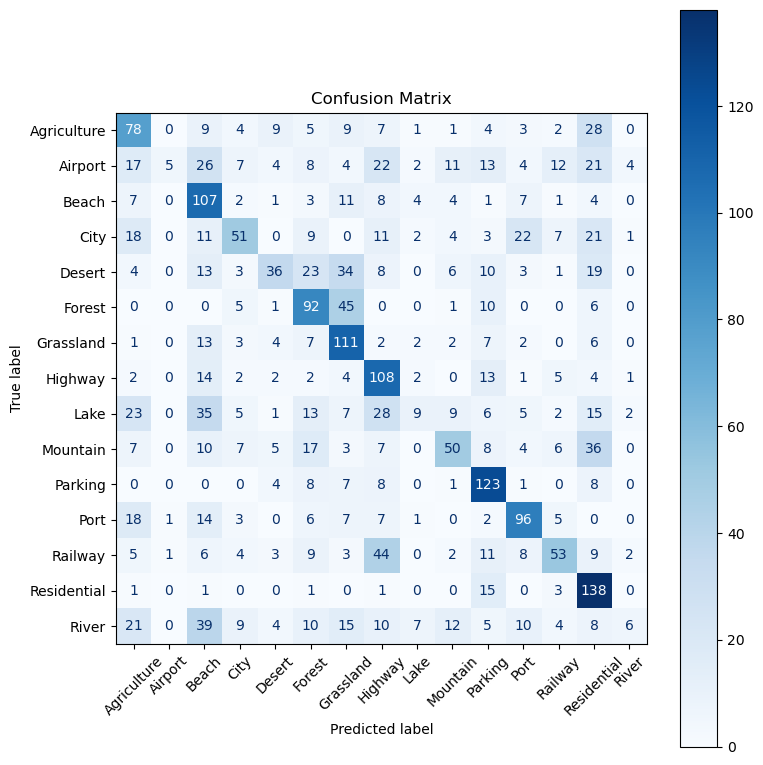

In [83]:
pred = svm.predict(test_set)
accuracy = accuracy_score(test_labels, pred)
print(f"Accuracy: {accuracy*100:.2f}%")
print(classification_report(test_labels, pred))

# Plotting the confusion matrix
cm = confusion_matrix(test_labels, pred)
cmdp = ConfusionMatrixDisplay(cm, display_labels=skyview_dataset.classes)
_, ax = plt.subplots(figsize=(8, 8))
cmdp.plot(cmap=plt.cm.Blues, xticks_rotation=45, ax=ax)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()